### Hand Gestures Torch Conv2d

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [2]:
train_dir = './../data/train/train'
test_dir = './../data/test/test'
classes = [dir for dir in os.listdir(train_dir) if not dir.startswith('.')]
classes

['1(bot)', '0(top)', '1(top)', '0(bot)', '2(top)', '2(bot)']

In [3]:
train_transform=v2.Compose([
        # size is 3840x2160 
        v2.RandomRotation(10),      # rotate +/- 10 degrees
        v2.RandomHorizontalFlip(),  # reverse 50% of images
        # v2.transforms.Pad((100, 50)),
        v2.Resize(54),              # resize shortest side
        v2.CenterCrop(96),          # crop longest side
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(dataset))

2930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0(bot)(0)


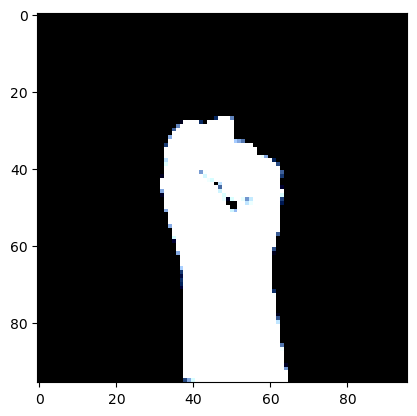

In [4]:
# function for the showing the image.
def show_image(img,label):
    print(f'Label: {dataset.classes[label]}({str(label)})')
    plt.imshow(img.permute(1,2,0))

show_image(*dataset[12])

In [5]:
torch.manual_seed(10)
val_size = len(dataset)//5 # 80 / 20 division 
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
print(len(train_ds), len(val_ds), len(test_ds))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

2344 586 761


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


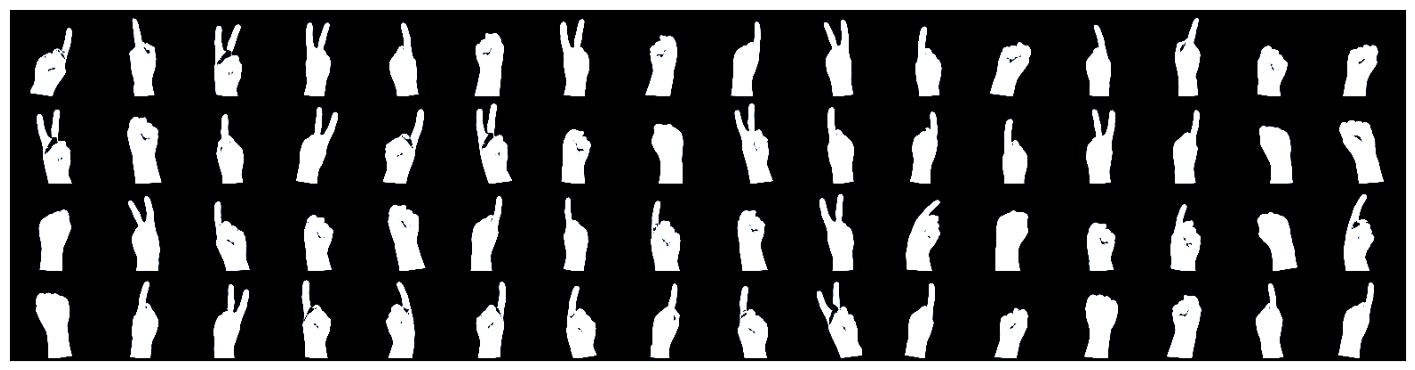

In [6]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Conv2d Model

In [9]:
# LeNet Architecture
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(36000, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

In [10]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
model = to_device(CnnModel(), device)
device

device(type='cpu')

In [11]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 96, 96])
out.shape: torch.Size([64, 6])
out[0]: tensor([ 0.1231,  0.0938, -0.1164, -0.0375,  0.0603, -0.0127],
       grad_fn=<SelectBackward0>)


In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.7939188480377197, 'val_acc': 0.17774493992328644}]

In [14]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [15]:
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.7869, val_loss: 1.7835, val_acc: 0.1777


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.3757, val_loss: 0.6672, val_acc: 0.6714


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7162, val_loss: 0.5089, val_acc: 0.7236


In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

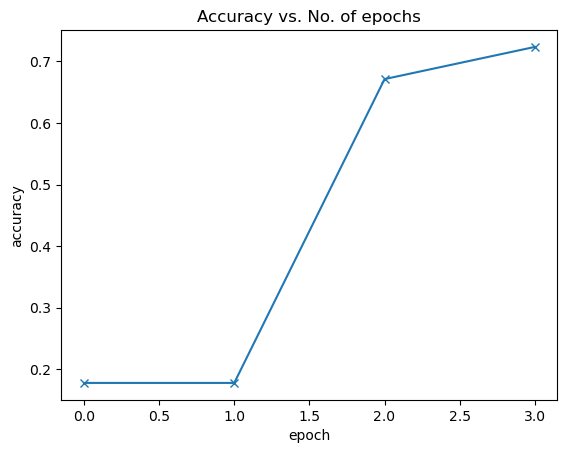

In [17]:
plot_accuracies(history)

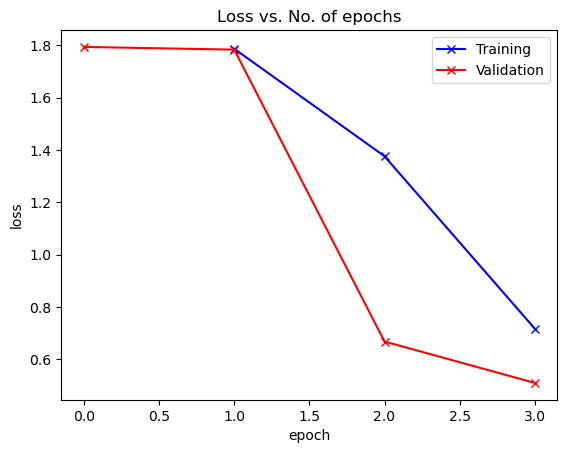

In [18]:
plot_losses(history)

In [19]:
evaluate(model, test_loader)

{'val_loss': 0.4703170359134674, 'val_acc': 0.7810562252998352}

### Prediction and classification report

In [22]:
from sklearn.metrics import classification_report

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       115
           1       0.76      0.79      0.77        86
           2       0.74      0.86      0.80        98
           3       0.98      0.89      0.93       276
           4       0.51      1.00      0.67        97
           5       0.00      0.00      0.00        89

    accuracy                           0.77       761
   macro avg       0.63      0.73      0.66       761
weighted avg       0.72      0.77      0.74       761



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# test loader prediction result
TEST_PRED=pd.DataFrame(columns=['true','predicted'])
TEST_PRED['true']=Y
TEST_PRED['predicted']=pred
TEST_PRED[TEST_PRED.true != TEST_PRED.predicted]

,true,predicted
41,0,1
44,0,1
87,0,1
88,0,1
89,0,1
...,...,...
756,5,4
757,5,4
758,5,4
759,5,4


# Hello


In [26]:
TEST_PRED[TEST_PRED.true != TEST_PRED.predicted]

,true,predicted
41,0,1
44,0,1
87,0,1
88,0,1
89,0,1
...,...,...
756,5,4
757,5,4
758,5,4
759,5,4
